In [119]:
import pandas as pd
import numpy as np
import os, pickle, datetime
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from great_tables import GT, md, html
import statsmodels.api as sm
warnings.filterwarnings('ignore')

In [120]:
# Load and combine the files
df = pd.read_csv('ProbSet2hjones-1.csv')
df

,wbcode,wbcountr,country,hjsample,hjinput,hjlogyl,hjlogkl,hjalogky,hjschool,hjloghl,...,hjlogl,hjmining,hjecorg,hjsocinf,hjyropen,hjgadp,hjengfra,hjeurfr,hjlogfr,hjlatitu
0,DZA,Algeria,ALGERIA,1,1,9.35998,10.30679,0.47341,2.39000,0.32026,...,15.49508,0.053,0,0.26467,4.000,0.529,0.000,0.006,2.637,36.720001
1,AGO,Angola,ANGOLA,1,1,7.06252,6.55136,-0.25558,3.09874,0.41523,...,15.27232,0.268,0,0.21333,0.000,0.427,0.000,0.000,2.443,-8.843000
2,BEN,Benin,BENIN,1,1,7.64465,7.54174,-0.05146,0.70000,0.09380,...,14.56503,0.009,0,0.24366,0.111,0.376,0.000,0.000,3.742,6.364000
3,BWA,Botswana,BOTSWANA,1,0,8.10645,9.19876,0.54615,3.70000,0.49580,...,12.90912,0.533,5,0.53428,0.356,0.713,0.000,0.000,3.179,-21.535999
4,BFA,Burkina faso,BURKINA FASO,1,1,6.95208,6.76837,-0.09186,3.78991,0.50785,...,15.26451,0.001,1,0.24917,0.000,0.498,0.000,0.000,2.646,12.049000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,PNG,Papua n.guinea,PAPUA N.GUINEA,1,0,7.92090,8.71693,0.39801,1.65000,0.22110,...,14.38005,0.192,5,0.31233,0.000,0.625,0.015,0.015,2.319,-6.600000
148,SLB,Solomon is.,SOLOMON IS.,0,0,8.79803,NaN,NaN,NaN,NaN,...,11.46972,-0.010,5,NaN,NaN,NaN,0.000,0.000,3.224,-9.625000
149,TON,Tonga,TONGA,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,0.006,5,NaN,NaN,NaN,0.000,0.000,3.770,-21.173000
150,VUT,Vanuatu,VANUATU,0,0,NaN,NaN,NaN,NaN,NaN,...,10.71054,NaN,3,NaN,NaN,NaN,0.011,0.049,3.429,-15.233000


In [121]:
df_graph = df[['hjlogyl','hjlogkl','wbcode']].dropna()
df_graph['output_per_worker']  = np.exp(df_graph['hjlogyl'])
df_graph['capital_per_worker'] = np.exp(df_graph['hjlogkl'])

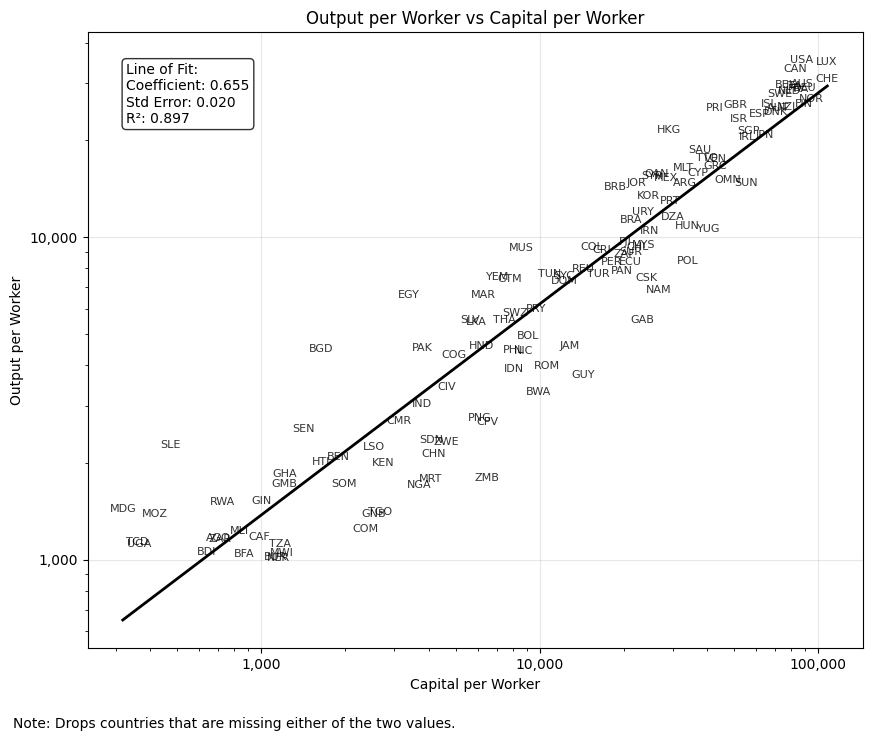

In [122]:
# scatter plot of output per worker and capital per worker with country abbreviations
plt.figure(figsize=(10, 8))
plt.title('Output per Worker vs Capital per Worker')
plt.xlabel('Capital per Worker')
plt.ylabel('Output per Worker')

# Set log scale before plotting
plt.xscale('log')
plt.yscale('log')

# Plot scatter points first (optional, can make them invisible)
plt.scatter(df_graph['capital_per_worker'], df_graph['output_per_worker'], alpha=0, s=0)

# Add country labels
for i, row in df_graph.iterrows():
    plt.text(row['capital_per_worker'], row['output_per_worker'], 
             row['wbcode'], fontsize=8, ha='center', va='center', alpha=0.8)

# Add line of best fit using log values
X = sm.add_constant(df_graph['hjlogkl'])
y = df_graph['hjlogyl']
model = sm.OLS(y, X).fit()

# Create line points for plotting
x_line = np.linspace(df_graph['hjlogkl'].min(), df_graph['hjlogkl'].max(), 100)
y_line = model.params[0] + model.params[1] * x_line

# Convert back to original scale for plotting
x_line_orig = np.exp(x_line)
y_line_orig = np.exp(y_line)

plt.plot(x_line_orig, y_line_orig, 'k-', linewidth=2, label='Line of best fit')

# Add regression statistics as text
coef = model.params[1]
std_err = model.bse[1]
r_squared = model.rsquared

stats_text = f'Line of Fit:\nCoefficient: {coef:.3f}\nStd Error: {std_err:.3f}\nR²: {r_squared:.3f}'
plt.text(0.05, 0.95, stats_text, transform=plt.gca().transAxes, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Format axis labels to avoid scientific notation
from matplotlib.ticker import FuncFormatter
def format_thousands(x, pos):
    return f'{x:,.0f}'

plt.gca().xaxis.set_major_formatter(FuncFormatter(format_thousands))
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_thousands))

plt.grid(True, alpha=0.3)

# Add a note at the bottom
plt.figtext(0.05, 0.01, 'Note: Drops countries that are missing either of the two values.', ha='left', fontsize=10, color='black')
plt.savefig('output_vs_capital_scatter.png', dpi=300, bbox_inches='tight')
plt.show()

In [123]:
def reg_util(df,x,y,out_path):
    df_sub = df[[x,y]].copy().dropna()
    X = sm.add_constant(df_sub[x])
    Y = df_sub[y]
    model = sm.OLS(Y, X).fit()
    with open(f'{out_path}0.tex', 'w') as f:
        f.write(model.summary().tables[0].as_latex_tabular())
    with open(f'{out_path}1.tex', 'w') as f:
        f.write(model.summary().tables[1].as_latex_tabular())
    return model

In [124]:
# Regress log output per worker on log capital per worker. Interpret your coefficients.
reg_util(df_graph,  
         'hjlogkl',
         'hjlogyl',
         './reg_output_capital')

reg_util(df,  
         'hjloghl',
         'hjlogyl',
         './reg_output_human_capital')

# Measuring Total Factor Productivity
Hall-Jones use a modified version of a Cobb-Douglas function to measure TFP. Specifically they measure:
$$y_i = \frac{K_i}{Y_i}^{\alpha/(1-\alpha)}h_iA_i,$$
where $h = H/L$ is human capital per worker. Note that for econometric purposes, $A_i$ arises as a residual term, not as something we have data for.

By taking the log of both sides, we get:

\begin{align*}
\log(y_i) &= \log\left(\frac{K_i}{Y_i}^{\alpha/(1-\alpha)}h_iA_i\right) \\
 &= \log\left(\frac{K_i}{Y_i}^{\alpha/(1-\alpha)}\right) + \log(h_i) + \log(A_i) \\
 &= \frac{\alpha}{1-\alpha}\log\left(\frac{K_i}{Y_i}\right) + \log(h_i) + \log(A_i),
\end{align*}
which we can estimate via linear regression or just by rearranging the equation further:
\begin{align*}
\log(A_i) &= \log(y_i) - \frac{\alpha}{1-\alpha}\log\left(\frac{K_i}{Y_i}\right) - \log(h_i) \\
A_i &= \exp(\log(y_i) - \frac{\alpha}{1-\alpha}\log\left(\frac{K_i}{Y_i}\right) - \log(h_i))
\end{align*}

- $\log(y_i)$ is hjlogyl
- $\frac{\alpha}{1-\alpha}\log\left(\frac{K_i}{Y_i}\right)$ is hjalogky
- $h_i$ is hjloghl
- $\alpha$ is assumed to be 1/3 in Hall-Jones

In [125]:
# Try to measure Total Factor Productivity
df_graph = df[['hjlogyl','hjloghl','hjalogky','wbcountr']].dropna()

df_graph['loga'] = df_graph['hjlogyl'] - df_graph['hjalogky'] - df_graph['hjloghl']
df_graph['A'] = np.exp(df_graph['loga'])

In [126]:
# Now replicate Table 1 from the paper:
df_graph['$Y/L$'] = np.exp(df_graph['hjlogyl'])
df_graph['$(K/Y)^{alpha/(1-alpha)}$'] = np.exp(df_graph['hjalogky'])
df_graph['$H/L$'] = np.exp(df_graph['hjloghl'])

for col in ['$Y/L$', '$(K/Y)^{alpha/(1-alpha)}$', '$H/L$', 'A']:
    val_USA = df_graph[df_graph['wbcountr'] == 'U.S.A.'][col].values[0]
    if col == 'A':
        print(f'USA value for {col} is {val_USA}.')
    df_graph[col] = df_graph[col] / val_USA

df_table = df_graph[['wbcountr', '$Y/L$', '$(K/Y)^{alpha/(1-alpha)}$', '$H/L$', 'A']].copy()
df_table.rename(columns={'wbcountr': 'Country'}, inplace=True)

countries = [
    'U.S.A.','Canada','Italy','Germany, West','France','U.K.',
    'Hong Kong','Singapore','Japan','Mexico','Argentina',
    'U.S.S.R.','India','China','Kenya','Zaire'
]
df_table = df_table[df_table['Country'].isin(countries)]

df_table['sort'] = df_table['Country'].map({
    'U.S.A.': 1, 'Canada': 2, 'Italy': 3, 'Germany, West': 4, 'France': 5,
    'U.K.': 6, 'Hong Kong': 7, 'Singapore': 8, 'Japan': 9, 'Mexico': 10,
    'Argentina': 11, 'U.S.S.R.': 12, 'India': 13, 'China': 14, 'Kenya': 15,
    'Zaire': 16
})

df_table = df_table.sort_values(by='sort').drop(columns='sort')

USA value for A is 6815.12639127175.


In [118]:
# turn into a GT table
gt_tbl = GT(df_table)
gt_tbl = gt_tbl.fmt_number(columns=['$Y/L$', '$(K/Y)^{alpha/(1-alpha)}$', '$H/L$', 'A'], decimals=3)

# Add a title, subtitle, and source note
gt_tbl = gt_tbl.tab_header(
    title="Productivity Calculations: Ratios to U.S. Values",
)

gt_tbl = gt_tbl.tab_source_note("The elements of this table are the empirical counterparts to the components of equation (3), all measured as ratios to the U. S. values. That is, the first column of data is the product of the other three columns.")

with open('table1.tex', 'w') as f:
    f.write(gt_tbl.as_latex().replace("\\$",'$').replace('\^','^').replace('\\{','{').replace('\\}','}'))